In [1]:
import numpy as np
import os
import re
import subprocess
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.cosmology import FlatLambdaCDM 
from astropy.table import Table
import astropy.units as u
from astropy.constants import L_sun

from synphot import SpectralElement
from synphot.models import Empirical1D

In [2]:
#Find the redshift of each object. 
z = dict()
d20 = open("../SED_models/double.20")
d22 = open("../SED_models/double.22")
for line in d20:
    x = line.split()
    y = d22.readline().split()
    z[y[-1]] = float(x[1])
d20.close()
d22.close()

In [3]:
#Load the bands with synphot. 
filt_files = {
    "R_SPECIAL":"M_SPECIAL_R.txt",
    "I_BESS": "M_BESS_I.txt",
    "v_HIGH": "v_HIGH.txt"
}
bp = dict()
for key in filt_files:
    skiprows=0
    if key=="v_HIGH":
        skiprows=2
    data = np.loadtxt("../../Filter_Curves/{}".format(filt_files[key]),skiprows=skiprows)
    wave = data[:,0]*10
    thru = data[:,1]
    bp[key] = SpectralElement(Empirical1D, points=wave[wave<10000.], lookup_table=thru[wave<10000.], keep_neg=True)
    print(key, bp[key].barlam(), bp[key].fwhm(), bp[key].rectwidth())

R_SPECIAL 6501.229535920617 Angstrom 1159.881393925198 Angstrom 1624.9974574790472 Angstrom
I_BESS 7908.260159757317 Angstrom 1335.7995225325858 Angstrom 1434.877194229439 Angstrom
v_HIGH 5531.766519253978 Angstrom 849.8588260783428 Angstrom 1195.1036753366664 Angstrom


In [4]:
class AGNModel(object):

    def __init__(self, Lbol=1e12*u.Lsun, D=10*u.Mpc):

        #Save the input parameter.
        self.Lbol = Lbol

        #Set the shape of the SED from https://skirt.ugent.be/skirt9/class_quasar_s_e_d.html
        self.AGN_model = list()
        self.AGN_model.append({'pl_coeff': 1./5., 'lam_min':0.001, 'lam_max':0.01 })
        self.AGN_model.append({'pl_coeff':-1.   , 'lam_min':0.01 , 'lam_max':0.1  })
        self.AGN_model.append({'pl_coeff':-3./2., 'lam_min':0.1  , 'lam_max':5.0  })
        self.AGN_model.append({'pl_coeff':-4.   , 'lam_min':5.0  , 'lam_max':1000.})

        #Get the normalization constants for each section. 
        for i,comp in enumerate(self.AGN_model):
            lam = np.logspace(np.log10(comp['lam_min']), np.log10(comp['lam_max']), 50, base=10.0)
            flam = lam**comp['pl_coeff']
            if i==0:
                norm = 1.0
            else:
                norm = flam_old[-1]/flam[0]
            flam_old = norm*flam
            self.AGN_model[i]['norm'] = norm
        
        #Normalize to the requested luminosity and distance. 
        SED_integral = 0
        for i, comp in enumerate(self.AGN_model):
            if comp['pl_coeff']!=-1.:
                alpha = comp['pl_coeff']+1
                SED_integral += comp['norm']/alpha * (comp['lam_max']**alpha - comp['lam_min']**alpha)
            else:
                SED_integral += comp['norm']*np.log(comp['lam_max']/comp['lam_min'])
        lum_factor = (Lbol/SED_integral) * (1./(4.*np.pi*D**2)) * (1./u.um)
        for i, comp in enumerate(self.AGN_model):
            self.AGN_model[i]['norm'] = self.AGN_model[i]['norm']*lum_factor.to(u.W/u.m**2/u.um)
        
        return
    
    def S_lam(self, wave):
        wave_use = wave.to(u.um).value
        norm = np.zeros(wave_use.shape)*self.AGN_model[0]['norm'].unit
        alpha = np.zeros(wave_use.shape)
        for comp in self.AGN_model:
            cond = (wave_use>=comp['lam_min']) & (wave_use<=comp['lam_max'])
            norm[cond] = comp['norm']
            alpha[cond] = comp['pl_coeff']
        return norm*(wave_use)**alpha 



(0.001, 100.0)

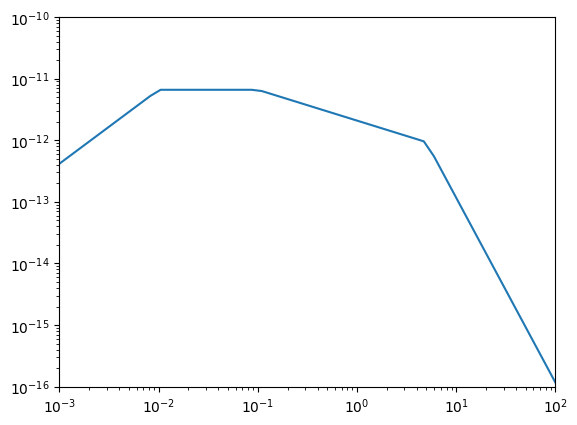

In [5]:
#Figure out the distance assumed by Marko by comparing to Figure 2 of Stalevski et al. (2012). Result: 10Mpc
wave = np.logspace(-3,2,50)*u.um
AGN = AGNModel(Lbol=1e11*L_sun, D=10*u.Mpc)
flam = AGN.S_lam(wave)
plt.plot(wave, wave*flam)
plt.loglog()
plt.ylim([1e-16,1e-10])
plt.xlim([1e-3, 1e2])

In [6]:
#Figure out all the SKIRTOR model families. 
skt_folder = "../../Calculations/SKIRTOR"
ls_output = subprocess.run("ls {}/b*.dat".format(skt_folder), shell=True, capture_output=True)
fnames = ls_output.stdout.decode('utf8').split()
angles = dict()
for fname in fnames:
    m = re.search("blueHotDogsPol_(.*?)_i(.*?)_sed.dat", fname)
    if not m:
        m = re.search("bHDPol_(.*?)_i(.*?)_sed.dat", fname)
    mname = m.group(1)
    if mname not in angles:
        angles[mname] = list()
    angles[mname].append(m.group(2))
model_families = list(angles.keys())

In [7]:
#Read the SKIRTOT models for each family. 
skt = dict()
for mf in model_families:
    skt[mf] = dict()
    for ang in angles[mf]:

        #Read the table.
        fname = '../../Calculations/SKIRTOR/blueHotDogsPol_{}_i{}_sed.dat'.format(mf, ang)
        if not os.path.exists(fname):
            fname =  '../../Calculations/SKIRTOR/bHDPol_{}_i{}_sed.dat'.format(mf, ang)

        skt[mf][ang] = Table.read(fname, format='ascii')

        #Rename the columns
        header = ["wavelength", "flux", "Q", "U", "V"]
        for i, col in enumerate(skt[mf][ang].colnames):
            skt[mf][ang].rename_column(col, header[i])

        #Save the flux.
        skt[mf][ang]["I"] = skt[mf][ang]["flux"] 

        #Calculate the polarization fraction. 
        skt[mf][ang]["P"] = -skt[mf][ang]["Q"]/skt[mf][ang]["flux"] * 100

        #Put the wavelengths in angstroms. 
        skt[mf][ang]["wavelength"] *= 1e4

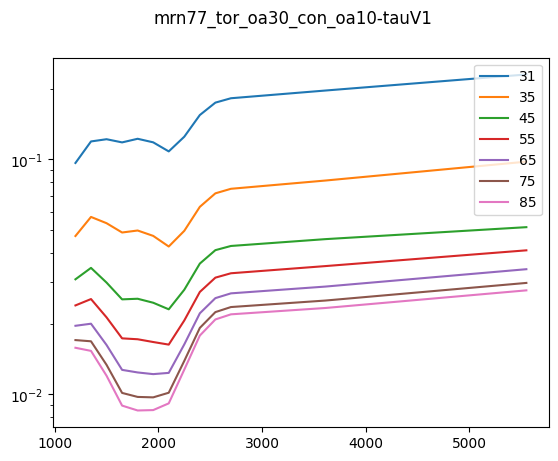

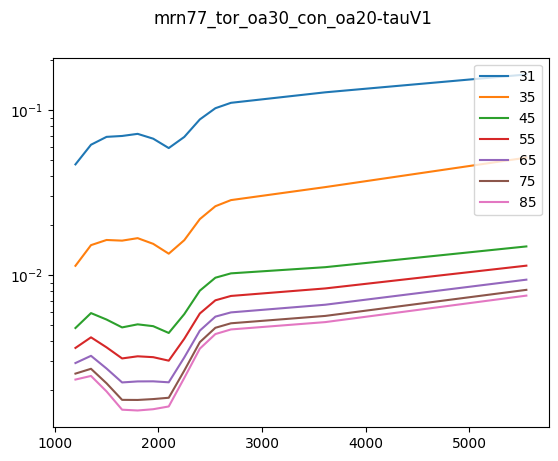

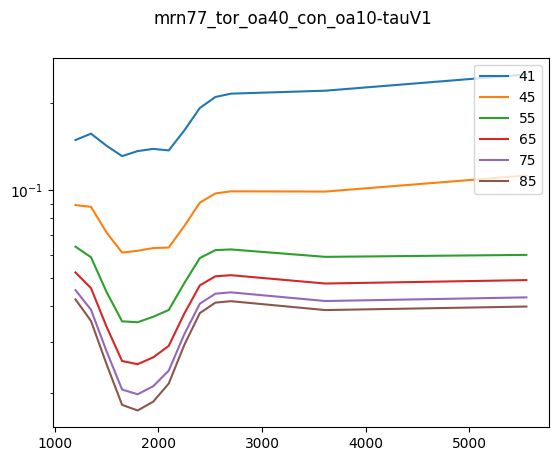

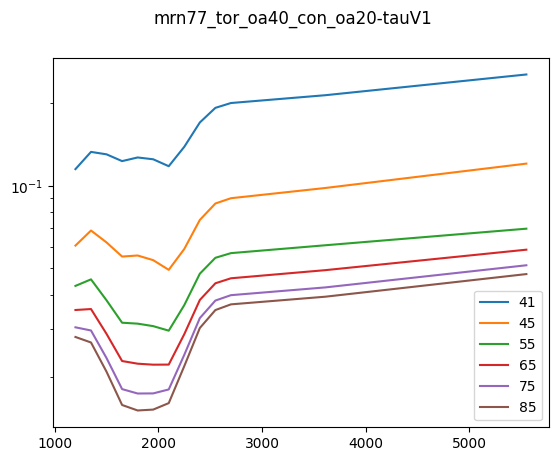

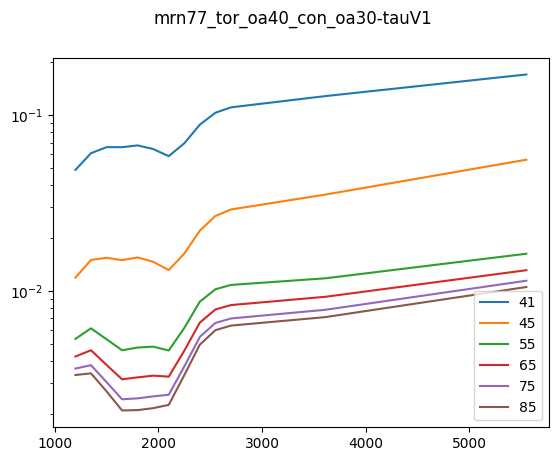

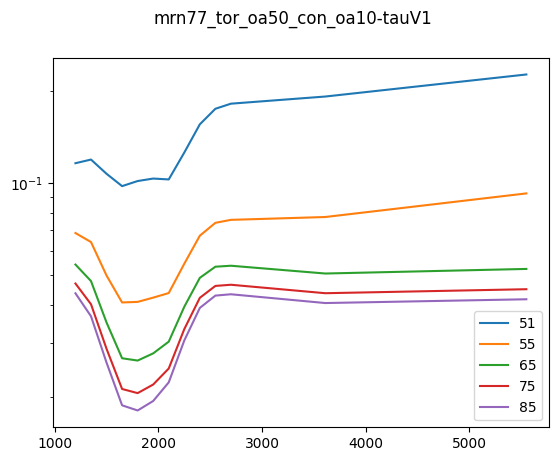

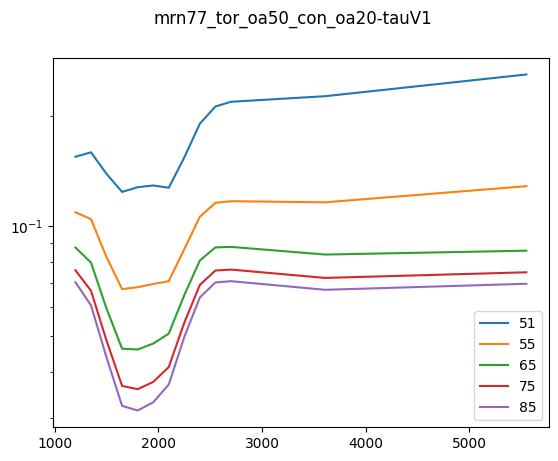

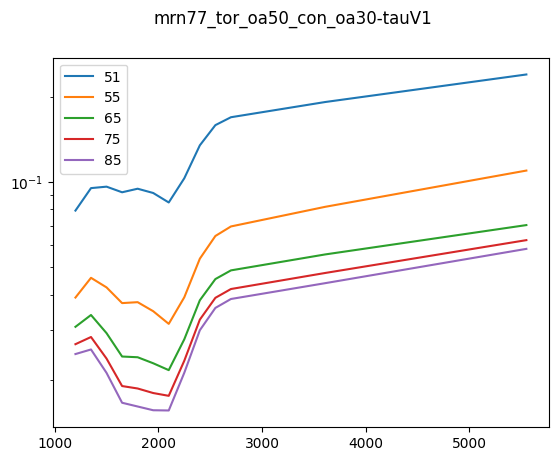

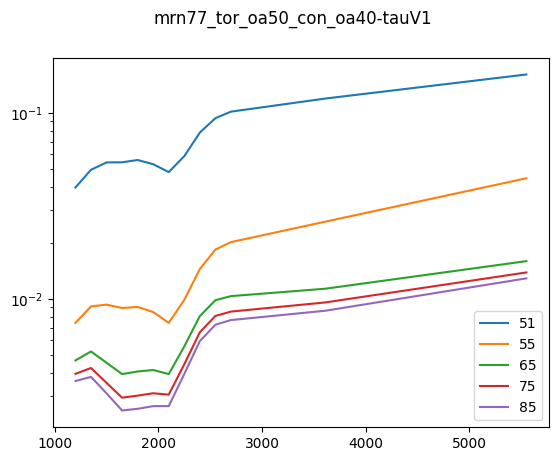

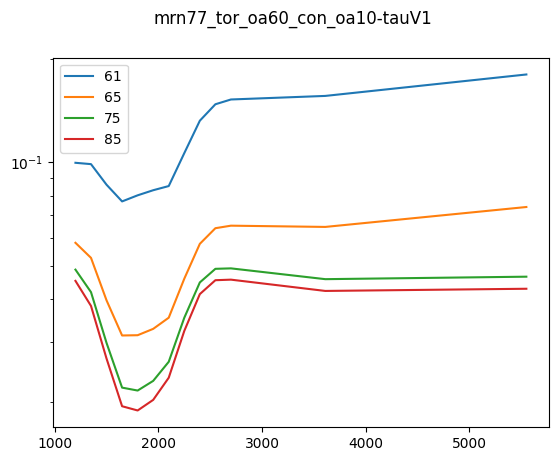

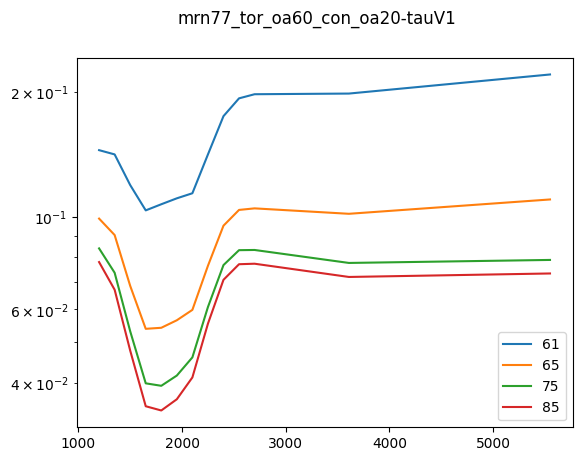

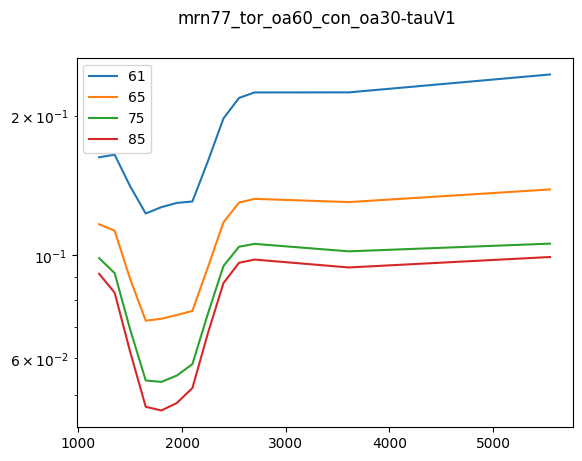

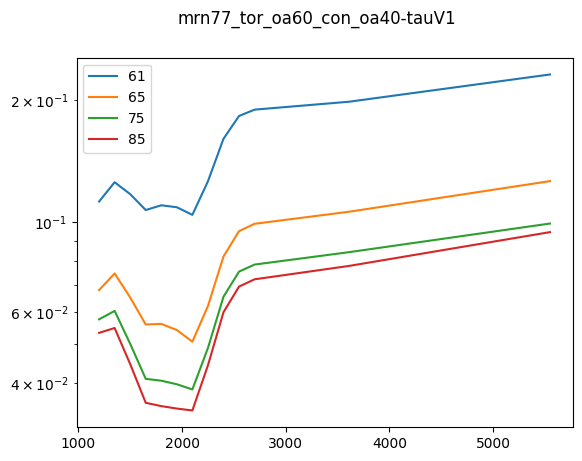

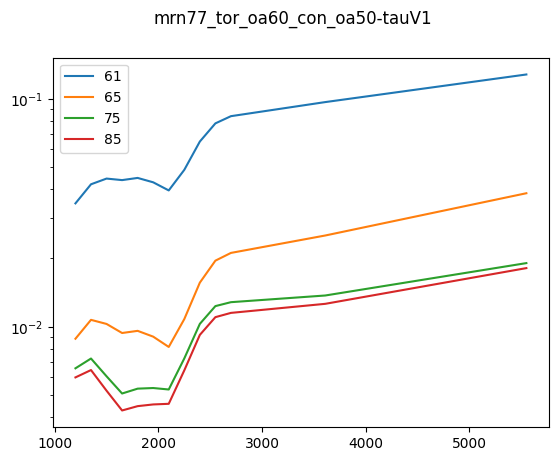

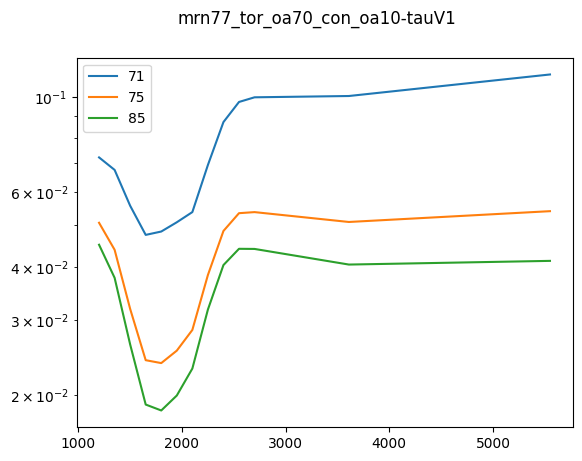

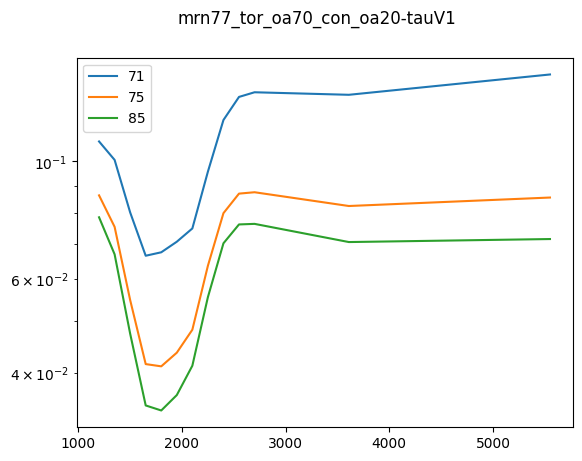

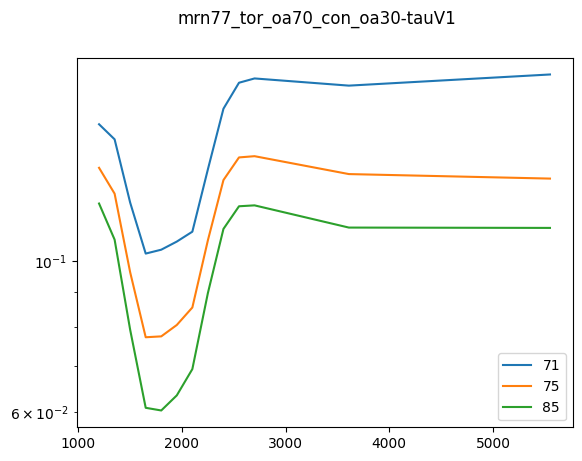

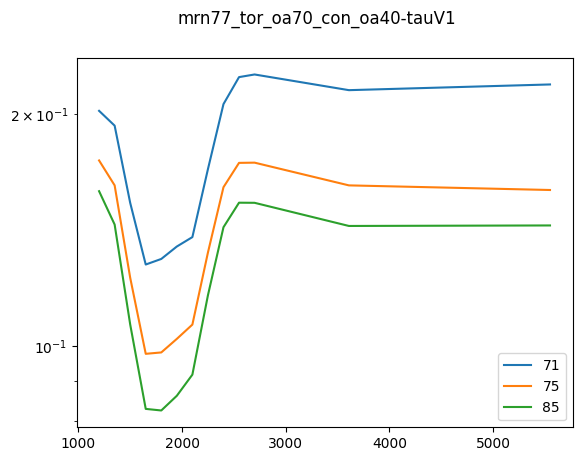

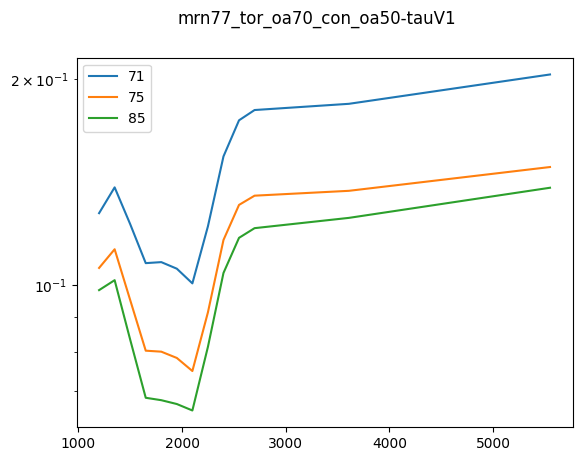

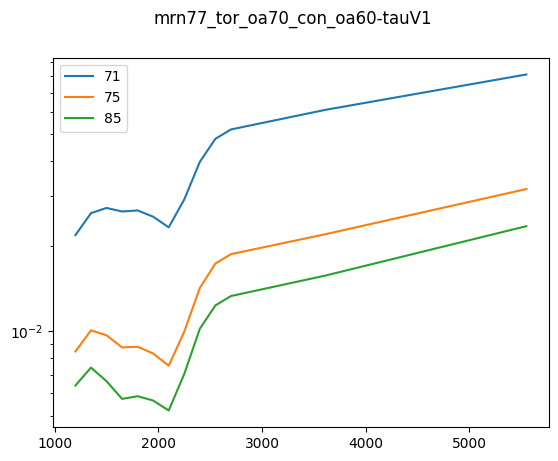

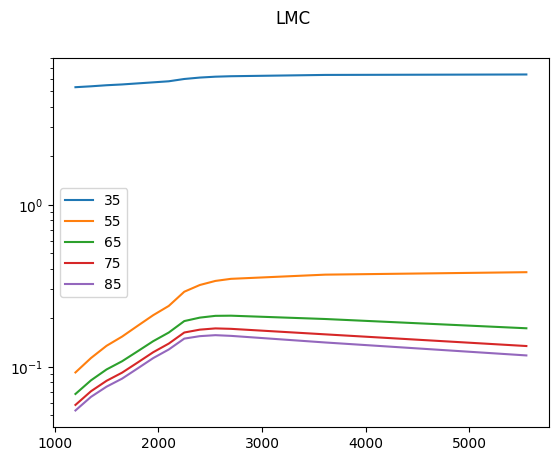

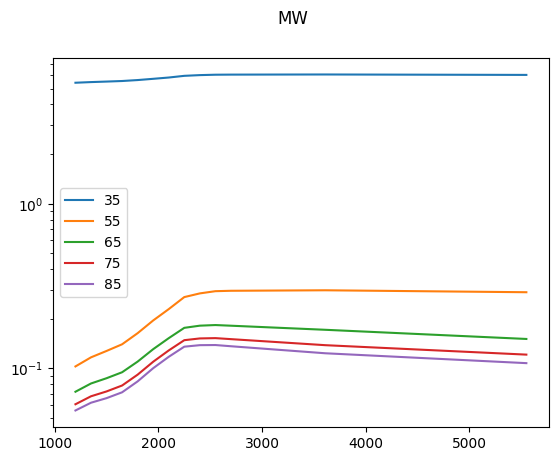

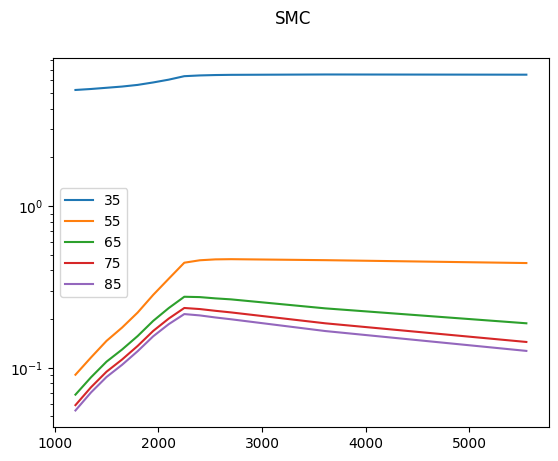

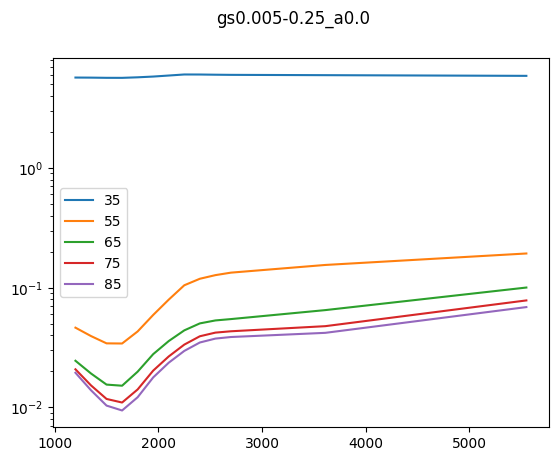

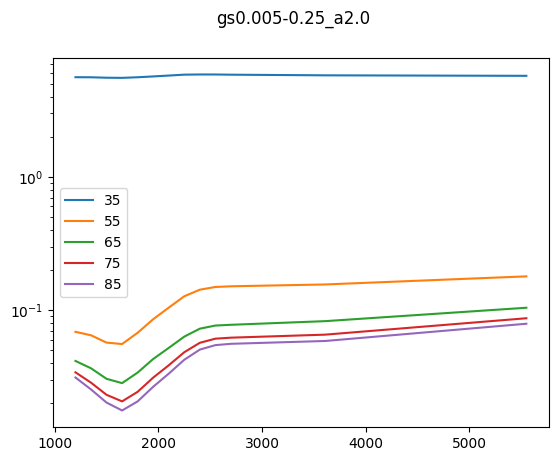

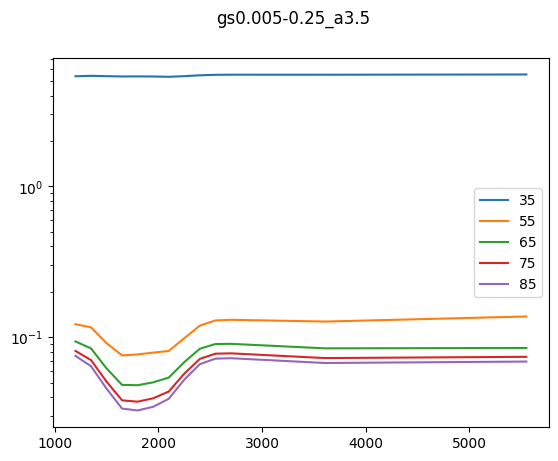

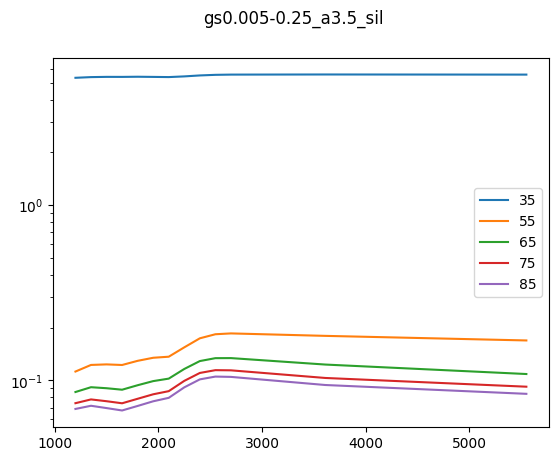

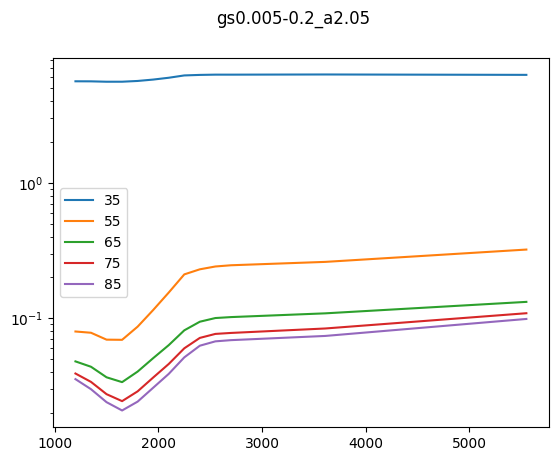

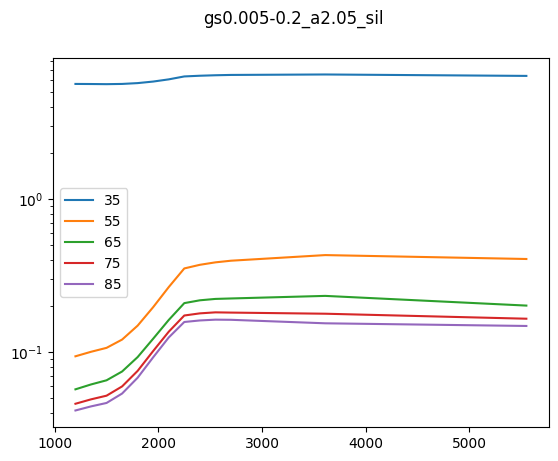

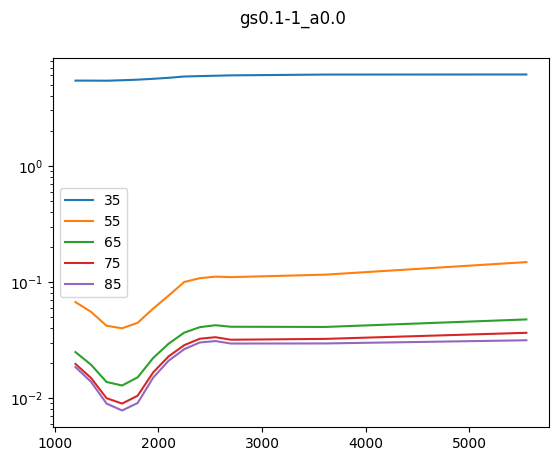

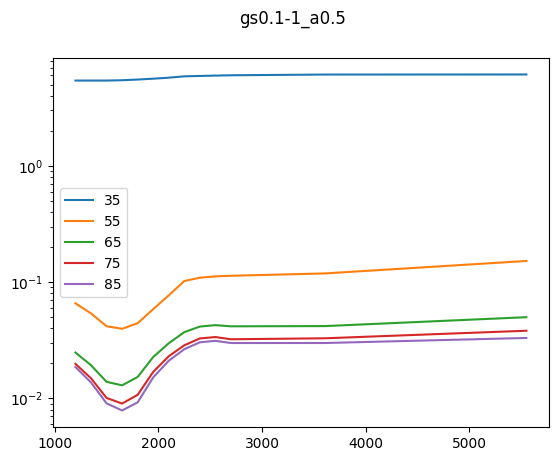

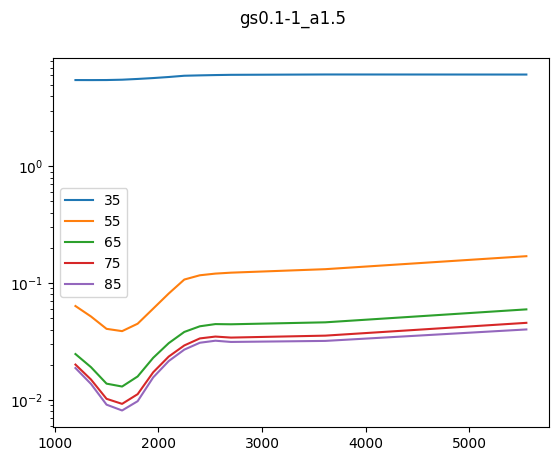

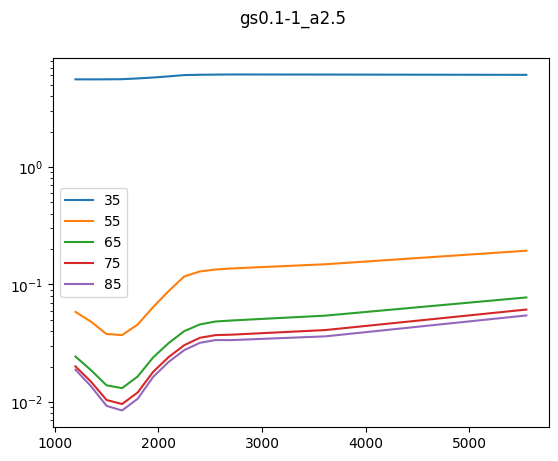

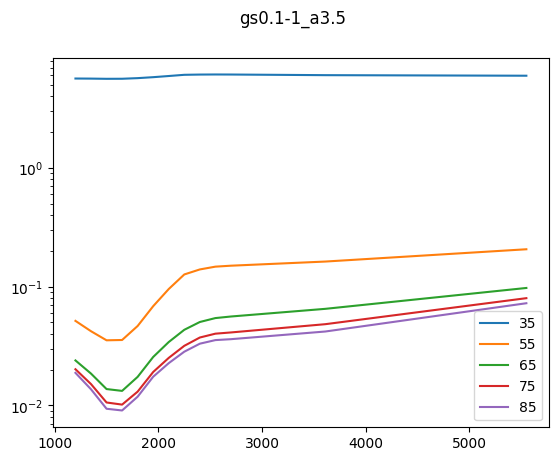

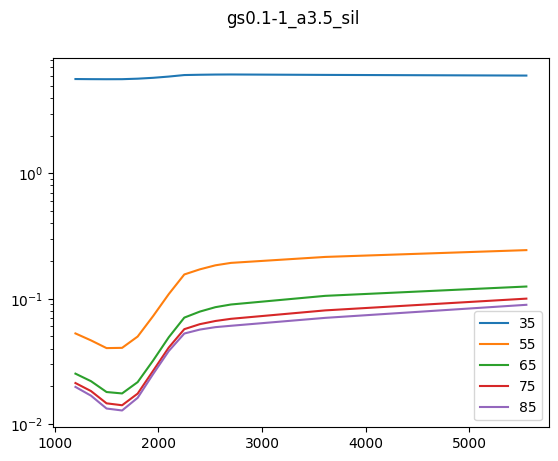

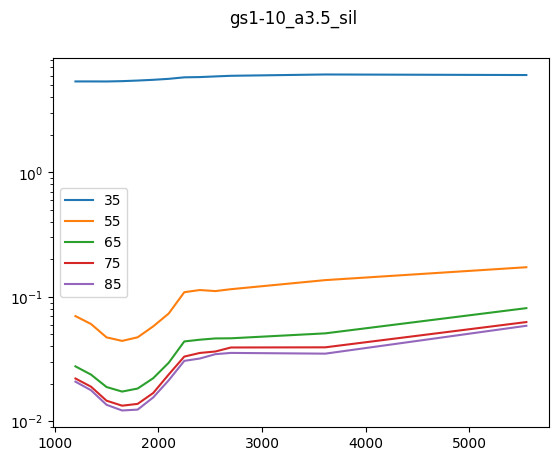

In [8]:
AGN = AGNModel(Lbol=1e12*L_sun, D=10*u.Mpc)
for mf in model_families:
    fig, ax = plt.subplots(1)
    for ang in angles[mf]:
        flam_tot = AGN.S_lam(skt[mf][ang]["wavelength"]*u.AA)
        ax.plot(skt[mf][ang]["wavelength"], skt[mf][ang]["I"]/flam_tot, label=ang)
    ax.set_yscale('log')
    ax.legend()
    fig.suptitle(mf)
    plt.show()